User Segmentation Using RFM and debt/income/credit_score

In [150]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load datasets

In [36]:
DATA_PATH = Path.cwd().parent / 'merged-df.csv'
df = pd.read_csv(DATA_PATH)
print(f"Loaded dataset with {df.shape[0]:,} rows and {df.shape[1]:,} columns")

Loaded dataset with 13,305,915 rows and 36 columns


In [116]:
user_df =  pd.read_csv("../final_features.csv")
print(f"Loaded dataset with {user_df.shape[0]:,} rows and {user_df.shape[1]:,} columns")

Loaded dataset with 1,219 rows and 32 columns


In [118]:
def _map_binary(series):
    truthy = {'y', 'yes', 'true', '1', 't'}
    falsy = {'n', 'no', 'false', '0', 'f'}
    s = series.astype(str).str.strip().str.lower()
    mapped = np.select([s.isin(truthy), s.isin(falsy)], [1, 0], default=np.nan)
    return pd.Series(mapped, index=series.index, dtype='float64')

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['card_acct_open_date'] = pd.to_datetime(df['card_acct_open_date'], errors='coerce')
df['card_expires'] = pd.to_datetime(df['card_expires'], errors='coerce')

df['use_chip_flag'] = _map_binary(df['use_chip']).fillna(0.0)
df['card_has_chip_flag'] = _map_binary(df['card_has_chip']).fillna(0.0)
df['card_on_dark_web_flag'] = _map_binary(df['card_card_on_dark_web']).fillna(0.0)

df['user_gender_code'], _ = pd.factorize(df['user_gender'])
df['card_brand_code'], _ = pd.factorize(df['card_card_brand'])
df['card_type_code'], _ = pd.factorize(df['card_card_type'])
df['merchant_state_code'], _ = pd.factorize(df['merchant_state'])
df['category_code'], _ = pd.factorize(df['category'])
df['mcc_code'], _ = pd.factorize(df['mcc'])

numeric_columns = [
    'user_current_age', 'user_retirement_age', 'user_birth_year', 'user_birth_month',
    'user_per_capita_income', 'user_yearly_income', 'user_total_debt',
    'user_credit_score', 'user_num_credit_cards', 'card_num_cards_issued',
    'card_credit_limit', 'card_year_pin_last_changed', 'user_latitude', 'user_longitude',
    'zip'
 ]
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
df['card_cvv'] = pd.to_numeric(df['card_cvv'], errors='coerce')

# weekend and spend helpers
df['is_weekend'] = df['date'].dt.weekday >= 5
df['positive_amount'] = df['amount'].clip(lower=0)
df['weekend_positive_amount'] = np.where(df['is_weekend'], df['positive_amount'], 0)

print("Preprocessing complete. Sample of engineered columns:")
df[['use_chip_flag', 'card_has_chip_flag', 'card_on_dark_web_flag', 'card_brand_code', 'card_type_code']].head()

Preprocessing complete. Sample of engineered columns:


,use_chip_flag,card_has_chip_flag,card_on_dark_web_flag,card_brand_code,card_type_code
0,0.0,1.0,0.0,0,0
1,0.0,1.0,0.0,0,0
2,0.0,1.0,0.0,0,0
3,0.0,1.0,0.0,1,0
4,0.0,1.0,0.0,0,0


In [39]:
df.columns

Index(['transaction_id', 'date', 'user_id', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc',
       'description', 'category', 'user_current_age', 'user_retirement_age',
       'user_birth_year', 'user_birth_month', 'user_gender', 'user_address',
       'user_latitude', 'user_longitude', 'user_per_capita_income',
       'user_yearly_income', 'user_total_debt', 'user_credit_score',
       'user_num_credit_cards', 'card_card_brand', 'card_card_type',
       'card_has_chip', 'card_cvv', 'card_expires', 'card_num_cards_issued',
       'card_credit_limit', 'card_acct_open_date',
       'card_year_pin_last_changed', 'card_card_on_dark_web', 'use_chip_flag',
       'card_has_chip_flag', 'card_on_dark_web_flag', 'user_gender_code',
       'card_brand_code', 'card_type_code', 'merchant_state_code',
       'category_code', 'mcc_code', 'is_weekend', 'positive_amount',
       'weekend_positive_amount'],
      dtype='object')

In [119]:
def most_frequent(series):
    if series.empty:
        return np.nan
    mode = series.mode(dropna=True)
    return mode.iloc[0] if not mode.empty else np.nan

customer_agg = df.groupby('user_id').agg(
    first_txn_date=('date', 'min'),
    last_txn_date=('date', 'max'),
    txn_count=('transaction_id', 'count'),
    total_spent=('amount', 'sum'),
    avg_spent=('amount', 'mean'),
    max_spent=('amount', 'max'),
    merchant_count=('merchant_id', 'nunique'),
    merchant_city_count=('merchant_city', 'nunique'),
    merchant_state_count=('merchant_state', 'nunique'),
    merchant_zip_count=('zip', 'nunique'),
    mcc_count=('mcc', 'nunique'),
    category_count=('category', 'nunique'),
    unique_cards=('card_id', 'nunique'),
    card_credit_limit=('card_credit_limit', 'first'),
    card_year_pin_last_changed=('card_year_pin_last_changed', 'first'),
    card_acct_open_date=('card_acct_open_date', 'first'),
    card_expires=('card_expires', 'first'),
    user_current_age=('user_current_age', 'first'),
    user_retirement_age=('user_retirement_age', 'first'),
    user_gender_code=('user_gender_code', 'first'),
    user_per_capita_income=('user_per_capita_income', 'first'),
    user_yearly_income=('user_yearly_income', 'first'),
    user_total_debt=('user_total_debt', 'first'),
    user_credit_score=('user_credit_score', 'first'),
    user_num_credit_cards=('user_num_credit_cards', 'first'),
    most_frequent_city=('merchant_city', most_frequent),
    most_frequent_category=('category', most_frequent),
    positive_spend=('positive_amount', 'sum'),
    weekend_positive_spend=('weekend_positive_amount', 'sum')
).reset_index()

customer_agg['first_txn_date'] = pd.to_datetime(customer_agg['first_txn_date'])
customer_agg['last_txn_date'] = pd.to_datetime(customer_agg['last_txn_date'])

reference_date = df['date'].max() + pd.Timedelta(days=1)

customer_agg['recency_days'] = (reference_date - customer_agg['last_txn_date']).dt.days
customer_agg['tenure_days'] = (customer_agg['last_txn_date'] - customer_agg['first_txn_date']).dt.days + 1
customer_agg.loc[customer_agg['tenure_days'] < 1, 'tenure_days'] = 1
customer_agg['txn_per_day'] = customer_agg['txn_count'] / customer_agg['tenure_days']

customer_agg['spend_per_txn'] = customer_agg['total_spent'] / customer_agg['txn_count'].replace(0, np.nan)
customer_agg['merchant_count_per_month'] = customer_agg['merchant_count'] / (customer_agg['tenure_days'] / 30.4375)
customer_agg['merchant_count_per_month'].replace([np.inf, -np.inf], np.nan, inplace=True)

customer_agg['card_account_age_years'] = ((reference_date - customer_agg['card_acct_open_date']).dt.days / 365.25)
customer_agg['card_account_age_years'] = customer_agg['card_account_age_years'].clip(lower=0)
customer_agg['card_time_to_expiry_years'] = ((customer_agg['card_expires'] - reference_date).dt.days / 365.25)
customer_agg['card_time_to_expiry_years'] = customer_agg['card_time_to_expiry_years'].fillna(0)

lookback_window_days = 365
lookback_start = reference_date - pd.Timedelta(days=lookback_window_days)
df_last_year = df[df['date'] >= lookback_start].copy()

last_year_agg = (
    df_last_year.groupby('user_id')
    .agg(
        positive_spend_last_year=('positive_amount', 'sum'),
        active_months_last_year=('date', lambda x: x.dt.to_period('M').nunique())
    )
    .reset_index()
    if not df_last_year.empty else
    pd.DataFrame(columns=['user_id', 'positive_spend_last_year', 'active_months_last_year'])
 )

if not last_year_agg.empty:
    last_year_agg['active_months_last_year'] = last_year_agg['active_months_last_year'].astype(float).clip(lower=1.0)

customer_agg = customer_agg.merge(last_year_agg, on='user_id', how='left')
customer_agg['positive_spend_last_year'] = customer_agg['positive_spend_last_year'].fillna(0.0)
customer_agg['active_months_last_year'] = customer_agg['active_months_last_year'].fillna(0.0)
customer_agg['avg_monthly_positive_spend'] = np.where(
    customer_agg['active_months_last_year'] > 0,
    customer_agg['positive_spend_last_year'] / customer_agg['active_months_last_year'],
    0.0
)

customer_agg['debt_to_income_ratio'] = customer_agg['user_total_debt'] / customer_agg['user_yearly_income'].replace(0, np.nan)
customer_agg['income_to_debt_ratio'] = customer_agg['user_yearly_income'] / customer_agg['user_total_debt'].replace(0, np.nan)

customer_agg['spend_to_limit_ratio'] = (
    customer_agg['avg_monthly_positive_spend'] /
    customer_agg['card_credit_limit'].replace(0, np.nan)
 )
customer_agg['spend_to_limit_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)

customer_agg['weekend_spend_ratio'] = np.where(
    customer_agg['positive_spend'] > 0,
    customer_agg['weekend_positive_spend'] / customer_agg['positive_spend'],
    0
)

customer_agg.replace([np.inf, -np.inf], np.nan, inplace=True)

credit_score_min, credit_score_max = 300, 850
credit_score_range = credit_score_max - credit_score_min
credit_score_component = 1 - (
    (
        customer_agg['user_credit_score']
        .clip(lower=credit_score_min, upper=credit_score_max)
        - credit_score_min
    ) / credit_score_range
)
credit_score_component = credit_score_component.fillna(0).clip(0, 1)

dti_component = (
    customer_agg['debt_to_income_ratio']
    .fillna(0)
    .clip(lower=0)
    / 1.5
).clip(0, 1)

spend_component = customer_agg['spend_to_limit_ratio'].fillna(0).clip(0, 1)

customer_agg['risk_of_default_score'] = (
    0.5 * credit_score_component
    + 0.3 * dti_component
    + 0.2 * spend_component
).clip(0, 1)

risk_level_bins = [-0.001, 0.33, 0.66, 1.0]
risk_level_labels = ['Low', 'Medium', 'High']
customer_agg['risk_level'] = pd.cut(
    customer_agg['risk_of_default_score'],
    bins=risk_level_bins,
    labels=risk_level_labels,
    include_lowest=True
)
customer_agg['risk_level'] = customer_agg['risk_level'].cat.add_categories(['Unscored']).fillna('Unscored')
customer_agg['risk_level'] = customer_agg['risk_level'].astype(pd.api.types.CategoricalDtype(
    categories=['Low', 'Medium', 'High', 'Unscored'],
    ordered=True
) )

customer_agg.head()

/tmp/nix-shell.dcXrrX/ipykernel_129206/1300535324.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_agg['merchant_count_per_month'].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/nix-shell.dcXrrX/ipykernel_129206/1300535324.py:92: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

,user_id,first_txn_date,last_txn_date,txn_count,total_spent,avg_spent,max_spent,merchant_count,merchant_city_count,merchant_state_count,...,card_time_to_expiry_years,positive_spend_last_year,active_months_last_year,avg_monthly_positive_spend,debt_to_income_ratio,income_to_debt_ratio,spend_to_limit_ratio,weekend_spend_ratio,risk_of_default_score,risk_level
0,0,2010-01-01 19:39:00,2019-10-30 13:25:00,1330,66825.16,50.244481,1128.47,204,125,38,...,0.079398,7882.66,12.0,656.888333,0.607233,1.646813,0.037323,0.254894,0.208002,Low
1,1,2010-01-01 15:09:00,2019-10-31 11:57:00,963,35074.78,36.422409,937.15,85,29,15,...,-2.833676,3896.29,12.0,324.690833,0.321583,3.109618,0.017934,0.309047,0.200631,Low
2,2,2010-01-04 17:02:00,2019-10-28 14:32:00,1065,29363.05,27.570939,298.30,68,9,6,...,-5.919233,2953.26,12.0,246.105000,2.945677,0.339481,0.031552,0.271619,0.467219,Medium
3,3,2010-01-13 01:55:00,2019-10-31 14:30:00,574,26327.53,45.866777,214.78,62,19,8,...,3.493498,2274.15,11.0,206.740909,0.668969,1.494838,0.015297,0.309823,0.290490,Low
4,4,2010-01-01 08:59:00,2019-10-25 20:24:00,1493,56913.68,38.120348,541.75,164,91,31,...,-5.672827,5412.18,12.0,451.015000,1.509361,0.662532,0.023369,0.292619,0.426492,Medium


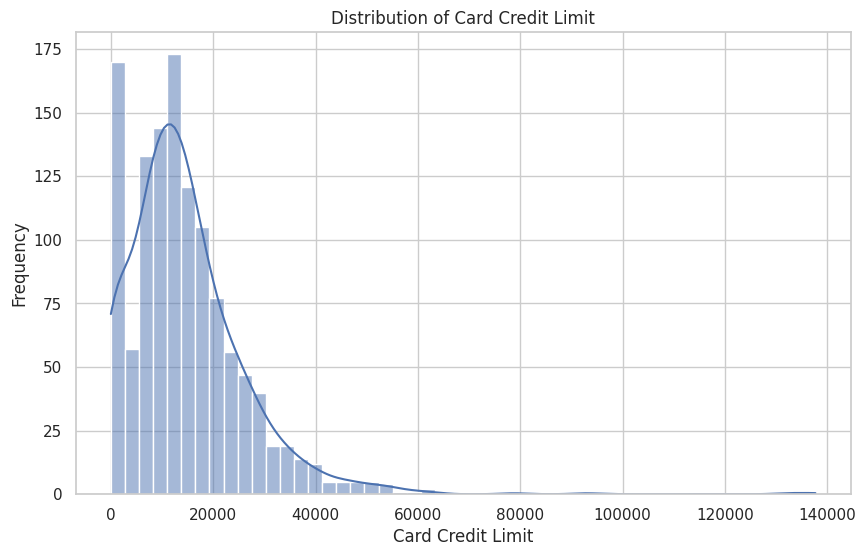

In [101]:
# plot the card_credit_limit distribution nicely
plt.figure(figsize=(10, 6))
sns.histplot(customer_agg['card_credit_limit'].dropna(), bins=50, kde=True)
plt.title('Distribution of Card Credit Limit')
plt.xlabel('Card Credit Limit')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Feature Analysis 

## Weekend Spend Ratio
The `weekend_spend_ratio` feature measures the proportion of a user's total positive transaction amount that occurs on weekends. This metric helps identify users whose spending behavior is more concentrated on weekends versus weekdays, which can be indicative of lifestyle, work schedule, or shopping preferences.

From the histogram below, we can see the most people spend 0.27 of their money on weekends. 


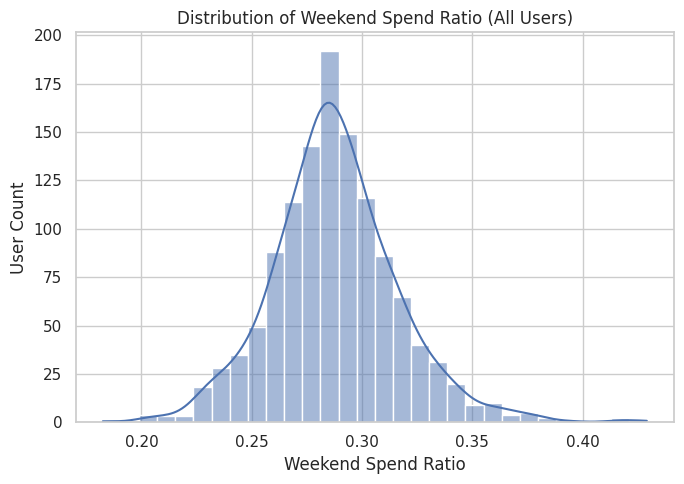

In [102]:
fig, ax = plt.subplots(figsize=(7,5))
sns.histplot(customer_agg['weekend_spend_ratio'], bins=30, kde=True, ax=ax)
ax.set_title('Distribution of Weekend Spend Ratio (All Users)')
ax.set_xlabel('Weekend Spend Ratio')
ax.set_ylabel('User Count')
plt.tight_layout()
plt.show()

## Risk of Default Score
We combine credit quality, leverage, and card utilization into a single indicator:
- **Credit score component (50%)** — lower FICO-like scores boost risk.
- **Debt-to-income component (30%)** — higher leverage pushes risk toward 1 after clipping at 1.5× income.
- **Average monthly spend vs. limit (20%)** — we divide each user's average monthly positive spend by their latest card limit to approximate utilization.


The formula: 
`credit_score_component`: 1 - ((x - 300)/ (850 - 300))
`dti_component`: `user_total_debt` / `yearly_income`
`spend_component`: `monthly avg spend of the latest 1y` / `card_credit_limit`
```
customer_agg['risk_of_default_score'] = (
    0.5 * credit_score_component
    + 0.3 * dti_component
    + 0.2 * spend_component
).clip(0, 1)
```
Scores are clipped to stay between 0 (least risky) and 1 (most risky).

In [103]:
risk_summary = customer_agg['risk_of_default_score'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]).round(3)
display(risk_summary)

count    1219.000
mean        0.351
std         0.144
min         0.004
10%         0.141
25%         0.249
50%         0.375
75%         0.445
90%         0.519
max         0.811
Name: risk_of_default_score, dtype: float64

### Spend distribution and mix by risk tier
The next cells profile total spend and transaction composition for each risk tier (Low, Medium, High, Unscored). From the histograms, we can see that the categories are similar across risk tiers.

,user_count,total_spent,avg_spent
risk_level,,,
Low,488.0,23683765.68,48532.31
Medium,718.0,32810856.50,45697.57
High,13.0,612711.47,47131.65
Unscored,NaN,NaN,NaN


/tmp/nix-shell.dcXrrX/ipykernel_129206/1882376688.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


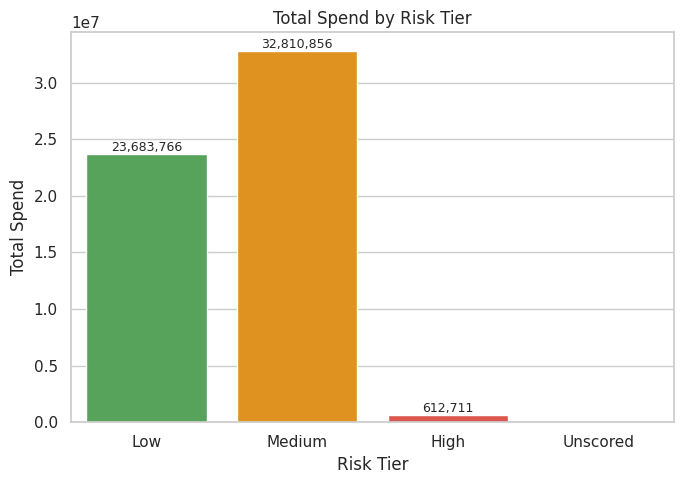

In [104]:
risk_level_order = ['Low', 'Medium', 'High', 'Unscored']
risk_spend_stats = (
    customer_agg.groupby('risk_level', observed=True)['total_spent']
    .agg(user_count='count', total_spent='sum', avg_spent='mean')
    .reindex(risk_level_order)
    .round({'total_spent': 2, 'avg_spent': 2})
)
display(risk_spend_stats)

fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(
    x=risk_spend_stats.index,
    y=risk_spend_stats['total_spent'],
    palette=['#4caf50', '#ff9800', '#f44336', '#9e9e9e'],
    ax=ax
)
ax.set_title('Total Spend by Risk Tier')
ax.set_xlabel('Risk Tier')
ax.set_ylabel('Total Spend')
for p, value in zip(ax.patches, risk_spend_stats['total_spent']):
    ax.annotate(
        f"{value:,.0f}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom',
        fontsize=9
    )
plt.tight_layout()
plt.show()

In [105]:
top_n = 5
risk_transactions = (
    df[['user_id', 'description', 'category', 'positive_amount']]
    .merge(customer_agg[['user_id', 'risk_level']], on='user_id', how='left')
)
risk_transactions = risk_transactions[
    risk_transactions['risk_level'].isin(risk_level_order)
].copy()
risk_transactions['risk_level'] = risk_transactions['risk_level'].astype('category').cat.reorder_categories(
    risk_level_order,
    ordered=True
)

def _top_k(df_group, column):
    aggregated = (
        df_group
        .dropna(subset=[column])
        .groupby(['risk_level', column], observed=True)['positive_amount']
        .sum()
        .reset_index()
    )
    aggregated['rank'] = aggregated.groupby('risk_level')['positive_amount'].rank(
        method='dense', ascending=False
    )
    top_k = aggregated[aggregated['rank'] <= top_n]
    return (
        top_k
        .sort_values(['risk_level', 'rank'])
        .rename(columns={'positive_amount': 'total_positive_amount'})
    )

top_descriptions = _top_k(risk_transactions, 'description')
top_categories = _top_k(risk_transactions, 'category')

print(f"Top {top_n} descriptions by spend within each risk tier:")
display(top_descriptions)

print(f"Top {top_n} categories by spend within each risk tier:")
display(top_categories)

Top 5 descriptions by spend within each risk tier:


/tmp/nix-shell.dcXrrX/ipykernel_129206/2870091605.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated['rank'] = aggregated.groupby('risk_level')['positive_amount'].rank(
/tmp/nix-shell.dcXrrX/ipykernel_129206/2870091605.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated['rank'] = aggregated.groupby('risk_level')['positive_amount'].rank(


,risk_level,description,total_positive_amount,rank
87,Low,Service Stations,2037854.79,1.0
70,Low,Money Transfer,1931707.48,2.0
45,Low,"Grocery Stores, Supermarkets",1694715.90,3.0
106,Low,Wholesale Clubs,1561001.34,4.0
64,Low,Miscellaneous Food Stores,1446906.79,5.0
178,Medium,Money Transfer,3180029.36,1.0
195,Medium,Service Stations,3026678.60,2.0
153,Medium,"Grocery Stores, Supermarkets",2353423.02,3.0
172,Medium,Miscellaneous Food Stores,2225898.57,4.0
214,Medium,Wholesale Clubs,2207805.55,5.0


Top 5 categories by spend within each risk tier:


,risk_level,category,total_positive_amount,rank
7,Low,Shopping & Retail,5991365.25,1.0
8,Low,Transportation & Travel,5824598.32,2.0
2,Low,Food & Dining,5253024.96,3.0
4,Low,Home & Utilities,2952292.42,4.0
1,Low,Financial & Insurance,2438956.77,5.0
16,Medium,Shopping & Retail,8465613.88,1.0
17,Medium,Transportation & Travel,8058517.14,2.0
11,Medium,Food & Dining,7613333.37,3.0
13,Medium,Home & Utilities,4067131.55,4.0
10,Medium,Financial & Insurance,3988885.73,5.0


High risk users tend to spend more money on financial and insurance products, while low risk users spend more on food and dining.

## Trend alignment with monthly spending
We measure how each user's month-over-month spending changes track the portfolio-wide trend. The correlation threshold of $0.25$ distinguishes users who roughly follow the overall pattern from those who diverge materially.

In [ ]:
monthly_total_spend = (
    df.set_index('date')['amount']
      .resample('MS')
      .sum()
      .rename('total_monthly_spend')
      .to_frame()
)

monthly_total_spend['monthly_diff'] = monthly_total_spend['total_monthly_spend'].diff().fillna(0)
overall_diff = monthly_total_spend['monthly_diff']
overall_months = monthly_total_spend.index

user_monthly_spend = (
    df.groupby(['user_id', pd.Grouper(key='date', freq='MS')])['amount']
      .sum()
      .reset_index()
      .rename(columns={'date': 'month', 'amount': 'user_monthly_spend'})
)

def _corr_with_overall(group):
    aligned = (
        group.set_index('month')
             .reindex(overall_months, fill_value=0)['user_monthly_spend']
    )
    user_diff = aligned.diff().fillna(0)
    if np.isclose(user_diff.var(), 0) or np.isclose(overall_diff.var(), 0):
        return 0.0
    return user_diff.corr(overall_diff)

monthly_correlations = (
    user_monthly_spend.groupby('user_id')
    .apply(_corr_with_overall)
    .rename('correlation_with_trend')
    .reset_index()
)

corr_threshold = 0.
monthly_correlations['trend_category'] = np.where(
    monthly_correlations['correlation_with_trend'] >= corr_threshold,
    'Follows Trend',
    'Does Not Follow Trend'
)

trend_summary = (
    monthly_correlations.merge(
        customer_agg[['user_id', 'total_spent']],
        on='user_id',
        how='left'
)
    .groupby('trend_category')
    .agg(
        user_count=('user_id', 'nunique'),
        avg_total_spent=('total_spent', 'mean')
    )
    .round({'avg_total_spent': 2})
    .reindex(['Follows Trend', 'Does Not Follow Trend'])
)

display(monthly_total_spend.reset_index())
display(monthly_correlations.head())
display(trend_summary)

/tmp/nix-shell.dcXrrX/ipykernel_129206/1961933822.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_corr_with_overall)


,date,total_monthly_spend,monthly_diff
0,2010-01-01,433069.34,0.00
1,2010-02-01,419671.62,-13397.72
2,2010-03-01,449766.88,30095.26
3,2010-04-01,432030.36,-17736.52
4,2010-05-01,466837.08,34806.72
...,...,...,...
113,2019-06-01,476697.86,-32117.79
114,2019-07-01,505290.97,28593.11
115,2019-08-01,500952.31,-4338.66
116,2019-09-01,496500.64,-4451.67


,user_id,correlation_with_trend,trend_category
0,0,0.059359,Does Not Follow Trend
1,1,0.081096,Does Not Follow Trend
2,2,0.109820,Does Not Follow Trend
3,3,0.107009,Does Not Follow Trend
4,4,0.117612,Does Not Follow Trend


,user_count,avg_total_spent
trend_category,,
Follows Trend,46,56570.27
Does Not Follow Trend,1173,46466.41


Monthly diff = (this month total of everyone - last month total of everyone)
For each user, we calculate the correlation between their monthly diff and the overall monthly diff.
If the correlation is above 0.25, we say the user "Follows Trend", otherwise "Does Not Follow Trend".
We assume that users who follow the trend are more likely to spend more.

### Monthly trend correlation distribution
The histogram below shows how users' month-over-month spending correlations stack up against the $0.25$ threshold, making it easy to spot segments that move with or against the portfolio trend.

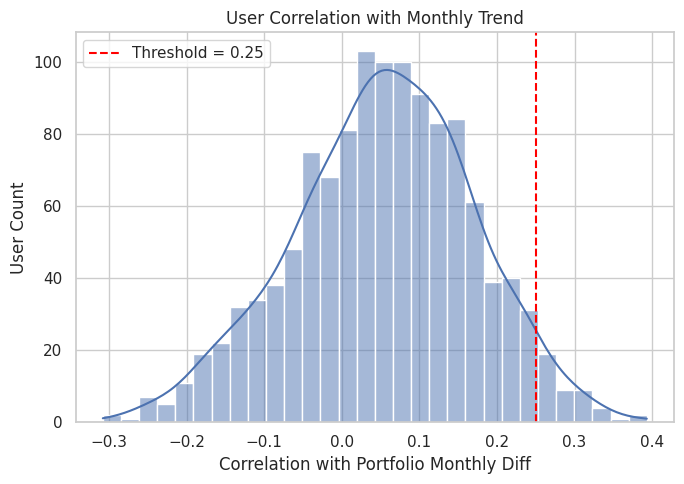

,user_count,avg_total_spent
trend_category,,
Follows Trend,46,56570.27
Does Not Follow Trend,1173,46466.41


In [108]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.histplot(
    monthly_correlations['correlation_with_trend'],
    bins=30,
    kde=True,
    ax=ax
)
ax.axvline(corr_threshold, color='red', linestyle='--', label=f'Threshold = {corr_threshold}')
ax.set_title('User Correlation with Monthly Trend')
ax.set_xlabel('Correlation with Portfolio Monthly Diff')
ax.set_ylabel('User Count')
ax.legend()
plt.tight_layout()
plt.show()

display(trend_summary)

### Clustering workflow

In [163]:
customer_agg = pd.read_csv("../final_features.csv")

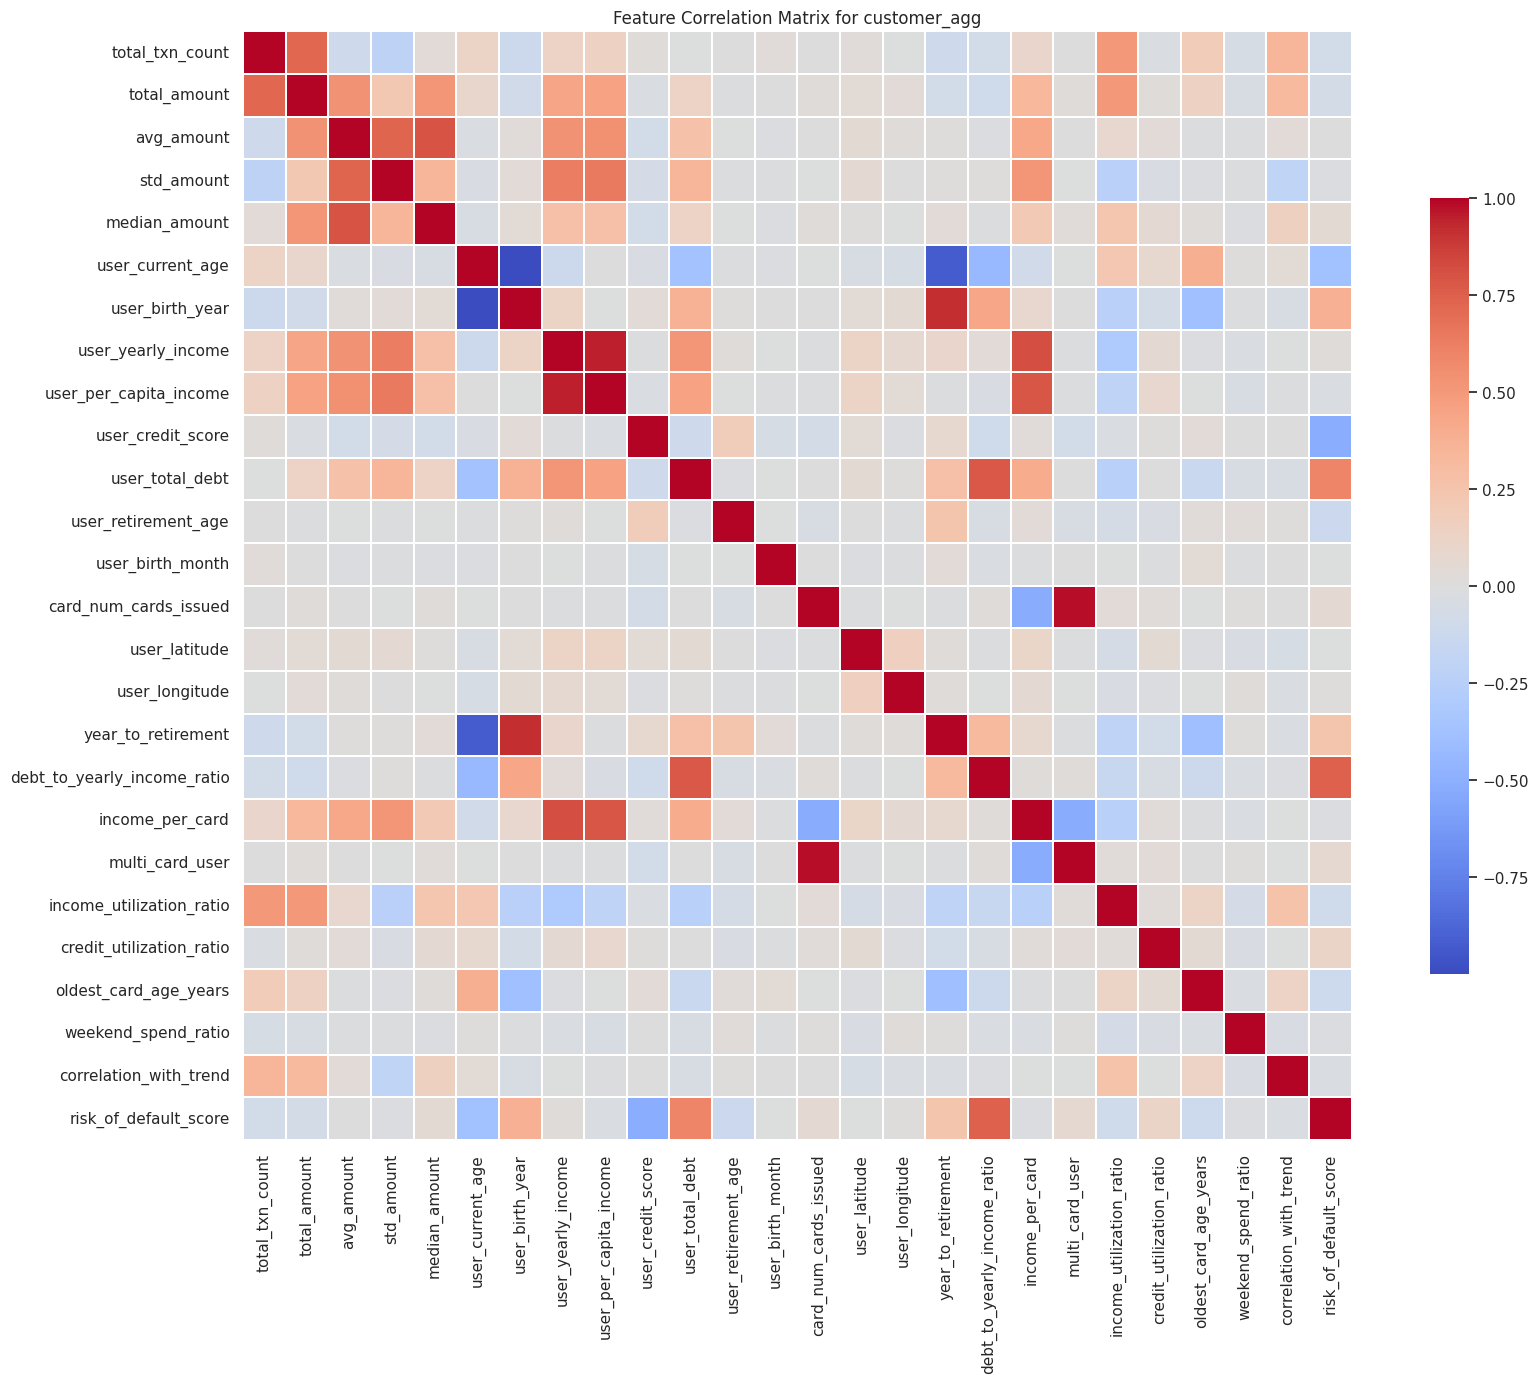

Feature pairs with high absolute correlation (>= 0.8):


,feature_a,feature_b,abs_corr
115,user_current_age,user_birth_year,0.999689
252,card_num_cards_issued,multi_card_user,0.981924
154,user_yearly_income,user_per_capita_income,0.951399
125,user_current_age,year_to_retirement,0.922395
144,user_birth_year,year_to_retirement,0.921600
164,user_yearly_income,income_per_card,0.817346


,feature,VIF
0,user_current_age,3021.382239
1,user_birth_year,3007.107556
2,multi_card_user,30.513394
3,card_num_cards_issued,28.467956
4,user_yearly_income,28.388960
5,income_per_card,15.645109
6,user_per_capita_income,14.614596
7,avg_amount,14.560250
8,year_to_retirement,12.595986
9,total_amount,11.886575


top_features = ['total_txn_count', 'debt_to_yearly_income_ratio', 'user_total_debt', 'risk_of_default_score', 'std_amount', 'median_amount', 'income_utilization_ratio', 'user_credit_score', 'user_birth_month', 'user_retirement_age', 'oldest_card_age_years', 'correlation_with_trend', 'credit_utilization_ratio', 'user_latitude', 'user_longitude', 'weekend_spend_ratio']


In [203]:
numeric_cols = customer_agg.select_dtypes(include=[np.number]).columns.drop('user_id', errors='ignore')
numeric_matrix = customer_agg[numeric_cols].copy()
numeric_matrix = numeric_matrix.replace([np.inf, -np.inf], np.nan)
median_impute = numeric_matrix.median(numeric_only=True)
numeric_matrix = numeric_matrix.fillna(median_impute)

corr_matrix = numeric_matrix.corr()
plt.figure(figsize=(18, 14))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.3,
    cbar_kws={'shrink': 0.7}
 )
plt.title('Feature Correlation Matrix for customer_agg')
plt.tight_layout()
plt.show()

upper_triangle_mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
high_corr_pairs = (
    corr_matrix.abs()
    .where(upper_triangle_mask)
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'feature_a', 'level_1': 'feature_b', 0: 'abs_corr'})
    .query('abs_corr >= 0.8')
    .sort_values('abs_corr', ascending=False)
 )
if not high_corr_pairs.empty:
    print('Feature pairs with high absolute correlation (>= 0.8):')
    display(high_corr_pairs)
else:
    print('No feature pairs exceed the absolute correlation threshold of 0.8.')

X_for_vif = numeric_matrix.assign(intercept=1)
vif_rows = []
for i, column in enumerate(X_for_vif.columns):
    if column == 'intercept':
        continue
    vif_value = variance_inflation_factor(X_for_vif.values, i)
    vif_rows.append({'feature': column, 'VIF': vif_value})
vif_df = (
    pd.DataFrame(vif_rows)
    .sort_values('VIF', ascending=False)
    .reset_index(drop=True)
)
display(vif_df)

# all features with VIF < 10
vif_lt_10 = vif_df[vif_df['VIF'] < 10]['feature'].tolist()
print(f"top_features = {vif_lt_10}")


In [204]:
numeric_cols = customer_agg[vif_lt_10].select_dtypes(include=[np.number]).columns.drop('user_id', errors='ignore')
feature_matrix = customer_agg[numeric_cols].copy()
feature_matrix = feature_matrix.fillna(feature_matrix.median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(feature_matrix)

pca = PCA()
principal_components = pca.fit_transform(X_scaled)

explained_variance = pd.DataFrame({
    'principal_component': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
    'explained_variance_ratio': pca.explained_variance_ratio_,
    'cumulative_variance_ratio': np.cumsum(pca.explained_variance_ratio_)
})
display(explained_variance.head(10))
pca_loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=numeric_cols
)

important_features = pca_loadings['PC1'].abs().sort_values(ascending=False).rename('abs_loading_PC1')
n_top = 5  # number of top features you want per component

top_features_by_pc = {}
for pc in pca_loadings.columns[:3]:  # PC1, PC2, PC3
    top_features_by_pc[pc] = (
        pca_loadings[pc]
        .abs()
        .sort_values(ascending=False)
        .head(n_top)
        .index.tolist()
    )

top_features = []
for pc, feats in top_features_by_pc.items():
    print(f"\nTop {n_top} features contributing to {pc}:")
    print(feats)
    top_features.append(feats[0])

,principal_component,explained_variance_ratio,cumulative_variance_ratio
0,PC1,0.170896,0.170896
1,PC2,0.117864,0.288760
2,PC3,0.087006,0.375766
3,PC4,0.076005,0.451771
4,PC5,0.072778,0.524550
5,PC6,0.065921,0.590471
6,PC7,0.064236,0.654706
7,PC8,0.061256,0.715962
8,PC9,0.056594,0.772556
9,PC10,0.053917,0.826474



Top 5 features contributing to PC1:
['user_total_debt', 'debt_to_yearly_income_ratio', 'risk_of_default_score', 'income_utilization_ratio', 'user_credit_score']

Top 5 features contributing to PC2:
['total_txn_count', 'income_utilization_ratio', 'correlation_with_trend', 'risk_of_default_score', 'std_amount']

Top 5 features contributing to PC3:
['median_amount', 'std_amount', 'risk_of_default_score', 'debt_to_yearly_income_ratio', 'user_latitude']


PC1: explains the risk score

PC2: how often spend (number of transactions and total spend)

PC3: how much user spend 

In [205]:
print(f"Top features selected for clustering: {top_features}")

X_features = customer_agg[top_features]
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X_features)

TARGET_K = 4  # Set to None to pick k via silhouette score
kmeans = KMeans(n_clusters=TARGET_K , random_state=42, n_init='auto')
labels = kmeans.fit_predict(X_scaled)
customer_agg_clustered = customer_agg.copy()
customer_agg_clustered['Cluster'] = labels

Top features selected for clustering: ['user_total_debt', 'total_txn_count', 'median_amount']


### Why k-means and how to explain the segments
1. **Transparent centroids:** k-means returns a centroid (mean feature vector) for each cluster. Comparing centroids shows which features drive each segment—for example, high `txn_count` plus low `recency_days` maps to “recent heavy spenders.”
2. **Feature importance cues:** The PCA loadings that selected `top_features` reveal which variables separate the data most. Combine them with centroid values to narrate segments.
3. **Per-cluster profiling:** Aggregating `customer_agg` by `Cluster` (means/medians, counts, proportions) builds human-readable personas. The `cluster_profile` table below already provides a starting point.
4. **Member-level explanations:** Distance to the assigned centroid clarifies how typical a user is. High distances flag edge cases worth reviewing individually.
5. **Visual storytelling:** Scatterplots or boxplots of the chosen features, colored by cluster labels, make differences intuitive for stakeholders.

### How the top features differentiate clusters
The next cells summarize and visualize how `merchant_count`, `merchant_city_count`, and `merchant_zip_count` shape each segment.

In [207]:
from IPython.display import display

top_feature_summary = (
    customer_agg_clustered.groupby('Cluster')[top_features]
    .agg(['mean', 'median', 'std'])
    .round(2)
)
display(top_feature_summary)
print("\nCorrelation matrix among selected features:")
display(customer_agg_clustered[top_features].corr().round(2))

user_total_debt                     total_txn_count                    \
                   mean    median       std            mean   median      std   
Cluster                                                                         
0              45464.84   44404.0  37742.07        20693.38  19300.0  5828.77   
1              38119.08   36810.0  29174.71         8899.13   8624.0  3024.51   
2              46047.91   48786.0  31328.31         9126.06   8924.0  3484.64   
3             138774.21  123198.0  52504.79        10364.58  10400.0  4233.13   

        median_amount                
                 mean median    std  
Cluster                              
0               30.28  29.59  13.38  
1               18.71  17.70   9.01  
2               53.45  49.40  14.96  
3               33.23  30.01  17.48


Correlation matrix among selected features:


,user_total_debt,total_txn_count,median_amount
user_total_debt,1.00,-0.01,0.13
total_txn_count,-0.01,1.00,0.04
median_amount,0.13,0.04,1.00


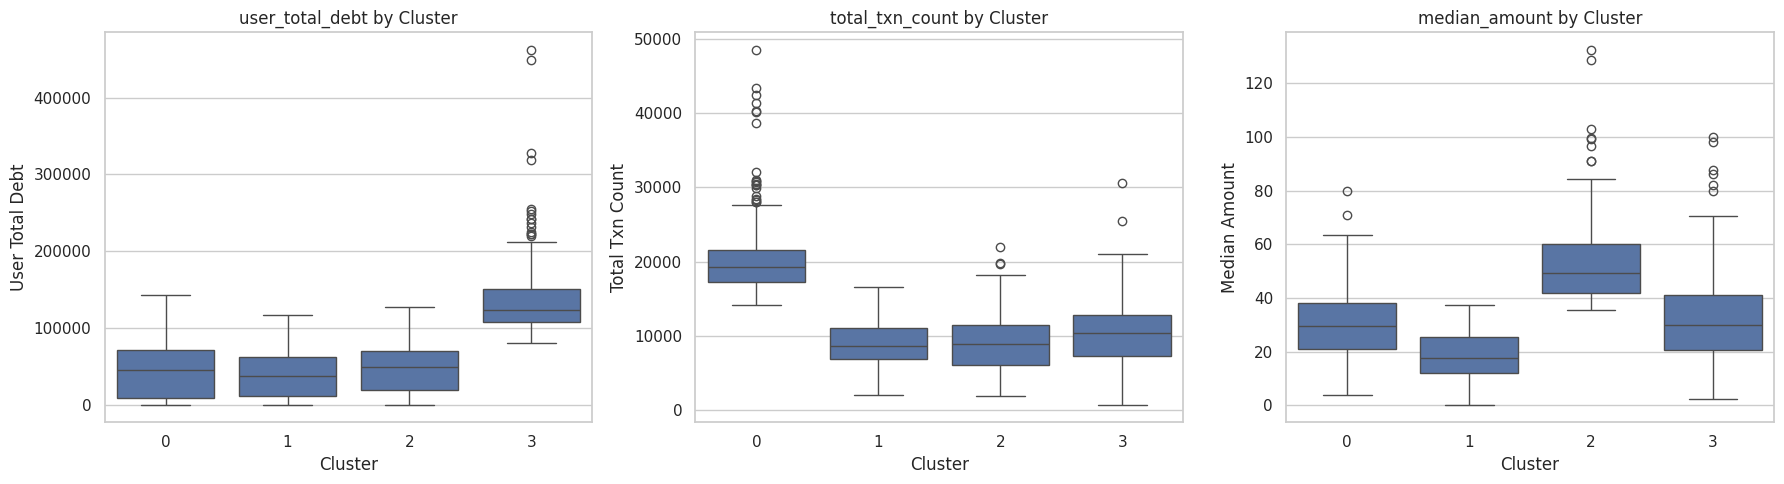

In [208]:
plot_df = customer_agg_clustered[['Cluster'] + top_features].copy()
plot_df['Cluster'] = plot_df['Cluster'].astype('category')

sns.set(style='whitegrid', context='notebook')
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, feature in zip(axes, top_features):
    sns.boxplot(data=plot_df, x='Cluster', y=feature, ax=ax)
    ax.set_title(f'{feature} by Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feature.replace('_', ' ').title())

plt.tight_layout()
plt.show()

0 – Regular Spenders  
Stable or slightly higher transaction count and amount. Their frequent, moderate spending suggests consistent routines and potential slight increases aligned with income cycles or seasonal needs.

1 – Conservative Budgeters  
Low, consistent, or even fewer transactions. Spending is low and controlled; unless incentives or discounts appear, they maintain minimal activity.

2 – Selective High-Value Purchasers  
Possible upcoming spike in transaction amount. After saving for a while, they tend to make infrequent but large, planned purchases, leading to volatility rather than steady increases.

3 – Debt-Burdened Consistent Spenders  
Potential slight decrease or volatility in transaction value. Their high debt levels may begin to constrain future spending, resulting in smaller or deferred purchases.
